In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from google.colab import files

In [2]:
# Allow file upload
uploaded = files.upload()

Saving Volcano plot_A30PvsAlpha.xlsx to Volcano plot_A30PvsAlpha.xlsx


In [5]:
# STEP 3: Load data
file_name = list(uploaded.keys())[0]
df = pd.read_excel(file_name, sheet_name='Sheet1')

In [6]:
df


,Protein IDs,Alpha A30P_day_1_1,Alpha A30P_day_1_2,Alpha _day_1_1,Alpha _day_1_2
0,Q8T008;A8DY95;A1Z8A7,-0.630707,-1.048800,-1.144903,NaN
1,P12252-4;P12252-5;P12252;E2QD73;P12252-6;P1225...,-1.834030,-2.350706,-1.258322,-1.648779
2,Q9VIC9,-1.984845,NaN,NaN,NaN
3,Q7YU24;O18412,-1.037977,-1.583549,-0.954641,-1.284686
4,P08255,0.648926,-1.958981,NaN,-0.369930
...,...,...,...,...,...
4427,Q9V771,NaN,NaN,NaN,1.243730
4428,O97159;E1JI46;Q59E34;O16102,-1.819801,-0.991771,-1.502260,-2.145797
4429,Q9VYQ8,-2.645119,-1.308859,-1.677010,-2.070542
4430,Q9VWT1;Q8IQX8,-1.364348,-1.976305,-1.323805,-1.671393


In [7]:

# Calculate mean for lpha A30P_day_1 and Alpha _day_1 replicates
# Clean up column names by stripping whitespace
df.columns = df.columns.str.strip()

df['Alpha A30P_day_1_Mean'] = df[['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']].mean(axis=1)
df['Alpha _day_1_Mean'] = df[['Alpha _day_1_1', 'Alpha _day_1_2']].mean(axis=1)

In [8]:
# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['Alpha A30P_day_1_Mean'] / df['Alpha _day_1_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['Alpha A30P_day_1_Mean'] - df['Alpha _day_1_Mean'].replace(0, np.nan))

In [9]:
# Perform t-tests (two-sample assuming equal variance)
t_stats, p_values = ttest_ind(
    df[['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']].values,
    df[['Alpha _day_1_1', 'Alpha _day_1_2']].values,
    axis=1, nan_policy='omit'
)

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


In [10]:
# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])


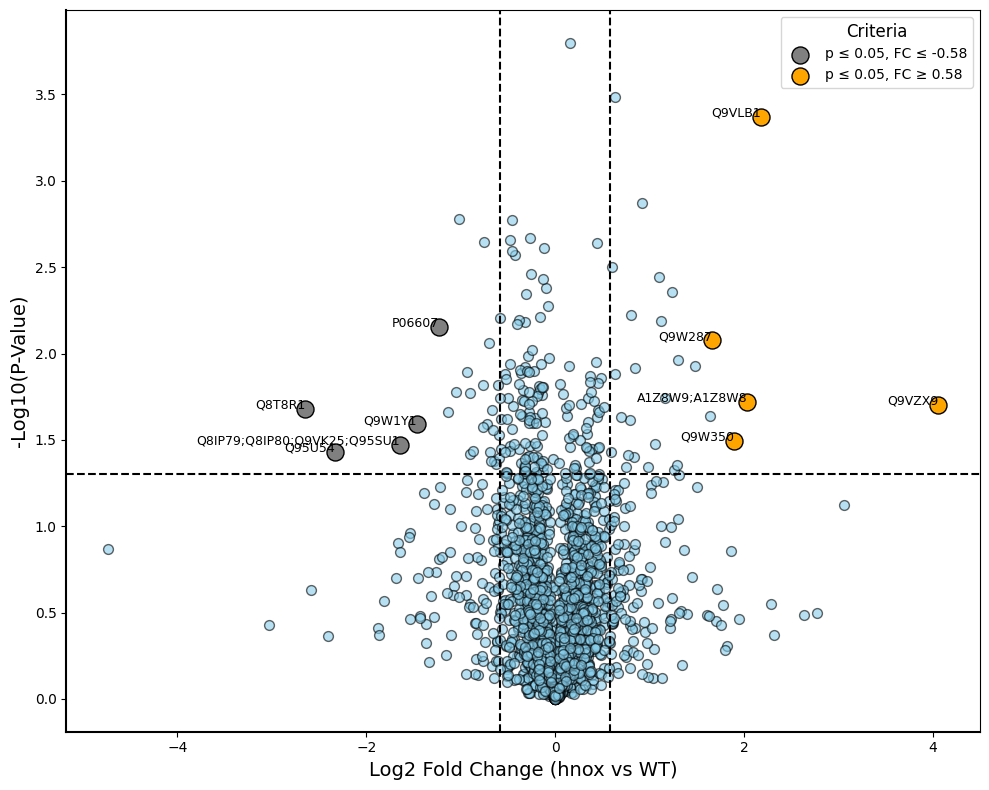

In [13]:
# Filter for statistically significant genes (P_Value < 0.05)
# Also drop any rows where P_Value or Log2_FC might be NaN to ensure clean selection
significant_and_clean_genes = df.dropna(subset=['P_Value', 'Log2_FC'])
significant_and_clean_genes = significant_and_clean_genes[significant_and_clean_genes['P_Value'] < 0.05]

# Select top 5 down-regulated genes from the significant set
down_regulated = significant_and_clean_genes.nsmallest(5, 'Log2_FC')

# Select top 5 up-regulated genes from the significant set
up_regulated = significant_and_clean_genes.nlargest(5, 'Log2_FC')

# Concatenate the top down and up-regulated genes
top_genes = pd.concat([down_regulated, up_regulated])


# Separate significant genes for coloring
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]

# Explicitly remove NaNs from right_candidates before plotting
right_candidates = right_candidates.dropna(subset=['Log2_FC', 'MinusLog10_P'])


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='#87CEEB')

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='grey', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58')
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='orange', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58')

# Add gene labels
for _, row in top_genes.iterrows():
    plt.text(row['Log2_FC'], row['MinusLog10_P'], row['Protein IDs'], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (hnox vs WT)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [15]:
print("Top 5 Down-Regulated Genes (Mean Values):")
display(down_regulated[['Protein IDs', 'Alpha A30P_day_1_Mean', 'Alpha _day_1_Mean', 'Log2_FC', 'P_Value']])

print("\nTop 5 Up-Regulated Genes (Mean Values):")
display(up_regulated[['Protein IDs', 'Alpha A30P_day_1_Mean', 'Alpha _day_1_Mean', 'Log2_FC', 'P_Value']])

Top 5 Down-Regulated Genes (Mean Values):


,Protein IDs,Alpha A30P_day_1_Mean,Alpha _day_1_Mean,Log2_FC,P_Value
39,Q8T8R1,-2.531900,0.113567,-2.645468,0.020872
1351,Q95U54,-2.088772,0.242816,-2.331588,0.037147
2599,Q8IP79;Q8IP80;Q9VK25;Q95SU1,-0.954023,0.687196,-1.641219,0.033821
2422,Q9W1Y1,0.182520,1.649294,-1.466774,0.025713
4423,P06607,0.817993,2.046877,-1.228884,0.006987



Top 5 Up-Regulated Genes (Mean Values):


,Protein IDs,Alpha A30P_day_1_Mean,Alpha _day_1_Mean,Log2_FC,P_Value
4260,Q9VZX9,2.328307,-1.729348,4.057654,0.019825
145,Q9VLB1,-1.273211,-3.454998,2.181787,0.000427
344,A1Z8W9;A1Z8W8,-0.221989,-2.255466,2.033477,0.019056
3167,Q9W350,-1.972224,-3.868806,1.896582,0.031939
3636,Q9W287,-0.689483,-2.349052,1.659569,0.008389
